# Analizando el modelo Sugarscape.
**A continuación se presenta un análisis de los datos arrojados por algunos experimentos realizados con el modelo de Sugarscape. Veremos la relación de la variable de dotación inicial (maximum-sugar-endowment y minimum-sugar-endowment) y las métricas del índice GINI, la cantidad de decesos por hambre (starvation), la riqueza per cápita y la cantidad promedio de cambios de azúcar tras aplicar las políticas de recaudación y redistribución. Los mapas de calor de cada experimentación pueden ser consultados a detalle en el otro notebook adjuntado.**
## Importando bibliotecas

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import re
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from mpl_toolkits.mplot3d import Axes3D
from itertools import combinations

sns.set()
ruta_datasets = 'Analisis espacio extendido/datasets'
carpeta_datasets= Path(ruta_datasets)
ruta_resultados = 'Analisis espacio extendido/resultados'


# Métodos auxiliares

In [2]:
def limpiar_dataframe(df):
    limpiado = df.drop(columns='visualization')
    limpiado = limpiado.drop(limpiado[limpiado['[step]'] == 0].index) # aquellas runs que no se iniciaron
    # aquellas runs invalidas
    limpiado = limpiado.drop(limpiado[limpiado['maximum-sugar-endowment'] <= limpiado['minimum-sugar-endowment']].index)
    limpiado = limpiado.drop(columns='[run number]')
    limpiado = limpiado.drop(columns='initial-population') #poblacion fija
    limpiado = limpiado.drop(columns='[step]') # en este punto, todas las runs son validas y llegaron a la it final
    # ordenamos los datos de forma ascendente
    limpiado = limpiado.sort_values(by=['minimum-sugar-endowment', 'maximum-sugar-endowment'], ascending=[True, True]).reset_index(drop=True)

    return limpiado
      

# Variables y clase

In [3]:
# Clase para almacenar datos utiles sobre cada espacio de parametros
import copy

class Experimento():

    def __init__(self, nombre= None, estrategia_id=None, redist=None, tax=None, dataset=None):
        self.nombre = nombre
        self.estrategia_id = estrategia_id
        self.redist = redist
        self.tax = tax
        self.dataset = dataset

    def proyecta_valores(self, metrica:str):
        """
            Método que devuelve un nuevo dataframe pivotado
            cuyas filas son la dotacion minima de azucar,
            columnas con dotacion maxima de azucar y cuyas
            casillas indican el dato en la metrica dada. 
            metrica (str): una metrica de interes que 
            corresponde a alguna de las siguientes:
            'avg-gini', 'avg-wealth', 'avg-diff', 'starvation'
            return: un nuevo dataframe con los datos proyectados
        """
        return self.dataset.pivot(index="minimum-sugar-endowment", columns="maximum-sugar-endowment", values=metrica)

    def mapa_calor(self,medida,titulo,ruta):
        """
            Genera un mapa de calor con los valores
            proyectados. Esta funcion se encarga
            de llamar a proyecta_valores antes
            de realizar el mapa de calor
            medida (str): una metrica de interes
            que corresponde a alguna de las siguientes:
            'avg-gini', 'avg-wealth', 'avg-diff', 'starvation'
            titulo (str): el titulo de la figura a crear
            ruta (str): la ruta en donde la figura se guardara
            return: un mapa de calor en la ruta especificada
            que se despliega para su visualizacion
        """
        datos_aplanados = self.proyecta_valores(medida)
        plt.figure(figsize=(12, 8)) 
        sns.heatmap(datos_aplanados, cmap='viridis',annot=False)
        plt.text(0, -0.5, titulo, fontsize=12, color='black', ha='left')
        plt.savefig(ruta,dpi=300, bbox_inches='tight')
        plt.show()

    def copiar(self):
        """
            Devuelve una nueva instancia copiando
            los valores de una existente
        """
        return copy.deepcopy(self)
    
    

In [4]:
# Las diferentes implementaciones de politicas seran medidas segun su reduccion del
# indice gini, reduccion de decesos por hambruna, riqueza per capita mas alta y
# diferencias de riquezas menos marcadas
tipos_analisis = {'Indice Gini':'avg-gini',
                  'Riqueza per cápita':'avg-wealth',
                  'Diferencia de riquezas entre un tick y otro':'avg-diff',
                  'Decesos por hambruna' : 'starvation'
                 }

experimentos = []

# Mapas de calor sobre el índice GINI, decesos por hambruna y riqueza per cápita

In [6]:
# Observando los resultados del modelo base sin politicas
datos_base = pd.read_csv('Analisis espacio extendido/datasets/simple.csv')
datos_base = limpiar_dataframe(datos_base)
#for llave in tipos_analisis.keys():
#    mapa_calor(datos_base, tipos_analisis[llave], llave, 'imagenes_espacio_extendido/comparativa/'+llave)

datos_base.head()

,maximum-sugar-endowment,minimum-sugar-endowment,taxation,redistribution,avg-gini,starvation,avg-wealth,total-wealth,avg-diff
0,11,10,no-collection,no-redistribution,0.491507,34088,28.338345,11097,1.770770
1,12,10,no-collection,no-redistribution,0.480694,33688,29.157425,12090,1.794605
2,13,10,no-collection,no-redistribution,0.476325,33431,28.800330,11333,1.773380
3,14,10,no-collection,no-redistribution,0.480453,32378,29.089935,12059,1.756035
4,15,10,no-collection,no-redistribution,0.470070,31766,29.688565,11205,1.779210


## Cargando los datos arrojados por la implementación de diferentes politicas de recaudación redistribución
Los archivos siguen el patron numero.recaudación-redistribución.csv

In [7]:
     
# Patron util para recuperar los nombres de las politicas
patron = r"^(\d+)\.(\w+)-(\w+)\.csv$"
archivos = sorted(
    [archivo for archivo in carpeta_datasets.glob("*.csv") if re.match(r"^(\d+)\.", archivo.name)],
    key=lambda x: int(re.match(r"^(\d+)\.", x.name).group(1))
)

for archivo in archivos:
    df = pd.read_csv(archivo)
    df = limpiar_dataframe(df)
    match = re.match(patron, archivo.name)
    if match:
        numero = match.group(1)  # Recupera el número inicial
        recaudacion = match.group(2)  # Política de recaudación
        redist = match.group(3)  # Política de redistribución
        print(f"Cargando: {archivo.name} | Número: {numero} | Recaudación: {recaudacion} | Redistribución: {redist}")
        nombre = recaudacion +' '+ redist
        # Generamos un nuevo objeto de clase Experimento para acceder a sus datos de forma mas rapida
        experimento = Experimento(nombre=nombre, estrategia_id=numero, redist=redist, tax=recaudacion, dataset=df)
        experimentos.append(experimento)


Cargando: 1.lineal-lineal.csv | Número: 1 | Recaudación: lineal | Redistribución: lineal
Cargando: 2.lineal-uniforme.csv | Número: 2 | Recaudación: lineal | Redistribución: uniforme
Cargando: 3.lineal-dirigidos.csv | Número: 3 | Recaudación: lineal | Redistribución: dirigidos
Cargando: 4.lineal-dinamico.csv | Número: 4 | Recaudación: lineal | Redistribución: dinamico
Cargando: 5.uniforme-uniforme.csv | Número: 5 | Recaudación: uniforme | Redistribución: uniforme
Cargando: 6.uniforme-lineal.csv | Número: 6 | Recaudación: uniforme | Redistribución: lineal
Cargando: 7.uniforme-dinamico.csv | Número: 7 | Recaudación: uniforme | Redistribución: dinamico
Cargando: 8.dinamico-dinamico.csv | Número: 8 | Recaudación: dinamico | Redistribución: dinamico
Cargando: 9.dinamico-uniforme.csv | Número: 9 | Recaudación: dinamico | Redistribución: uniforme
Cargando: 10.dinamico-lineal.csv | Número: 10 | Recaudación: dinamico | Redistribución: lineal


# Analizando los resultados
Ahora que ya tenemos los datos con las métricas arrojados por cada uno de los experimentos con las políticas, analicemos los mejores resultados 

## Metodos auxiliares

In [8]:
def es_optimo(metrica, valor1, valor2):
    """
        Metodo auxiliar que indica si el 
        primer renglon especificado es 
        mas optimo que el segundo
        Las metricas posibles son:
        'avg-gini', 'avg-wealth', 'avg-diff','starvation'
    """
    # Nos interesa reducir el gini, los cambios de azucar y los decesos por hambruna
    if metrica in ['avg-gini', 'avg-diff', 'starvation']:
        return valor1 < valor2
    # Nos interesa maximizar la riqueza
    else:
        return valor1 > valor2


def mejores_resultados(experimentos: list, metrica: str):
    """
        Método que realiza la comparativa entre todos los datasets
        y se queda con el renglon con el valor más óptimo según 
        la métrica.
        Las métricas posibles son:
        'avg-gini', 'avg-wealth', 'avg-diff', 'starvation'
        
        datasets (list): una lista de los experimentos realizados a comparar
        metrica (str): un string con el nombre de la metrica a tomar en cuenta.  
        returns: un dataset con los valores más óptimos según 
        la metrica establecida.
    """
    # Copia el primer dataset como base
    datasets = [experimento.dataset for experimento in experimentos]
    base = datasets[0].copy()
    # nueva columna en el dataset que indica el id de la politica mas optima
    base['etiqueta'] = 0
    # Itera sobre las filas de la base
    for index, row in base.iterrows():
        # Valor óptimo actual y su índice
        valor_optimo = row[metrica]
        etiqueta_optima = 1
        # Itera sobre los otros datasets para comparar valores en el mismo índice
        for i, ds in enumerate(datasets):
            # Obtener el valor propuesto en la misma posición
            valor_propuesto = ds.loc[index, metrica]
            if es_optimo(metrica, valor_propuesto, valor_optimo):
                valor_optimo = valor_propuesto
                etiqueta_optima = i 
                # Copiar toda la fila para actualizar `base`
                base.loc[index] = ds.loc[index]
                base.at[index, 'etiqueta'] = etiqueta_optima

    return base


## Metodos auxiliares para representación visual

In [9]:

def representacion_visual(df, titulo, ruta):
    """
        Genera un mapa de calor para los mejores resultados arrojados
        por el metodo mejores_resultados
        df (pd.Dataframe): un dataframe con los resultados a
        mostrar 
    """
    etiquetas = df.pivot(index="minimum-sugar-endowment", columns="maximum-sugar-endowment", values='etiqueta')
    colores = ['beige', 'gray', 'red', 'orange', 'yellow', 
               'lime', 'cyan', 'blue', 'pink', 'saddlebrown']
    # Creamos una máscara para los valores NaN
    mask = etiquetas.isna()
    
    plt.figure(figsize=(10, 8))
    
    # Generar el heatmap
    heatmap = sns.heatmap(etiquetas, annot=False, cmap=colores, cbar=True,
                          linecolor='gray', mask=mask,
                          vmin=0, vmax=9)  # Establecemos los límites de la barra de colores

    # Color para los NaN
    heatmap.set_facecolor('lightgrey')
    # Personalizar la barra de colores
    cbar = heatmap.collections[0].colorbar
    cbar.set_ticks(np.arange(10))  # Aseguramos que haya 10 ticks (de 0 a 9)
    cbar.set_ticklabels([f"{i + 1}: {experimentos[i].nombre}" for i in range(10)])  # Etiquetas personalizadas

    # Título y guardado del gráfico
    plt.title(titulo)
    plt.savefig(ruta, dpi=300, bbox_inches='tight')
    plt.show()

## Mejor politica para reducir el indice Gini segun el rango de riqueza inicial

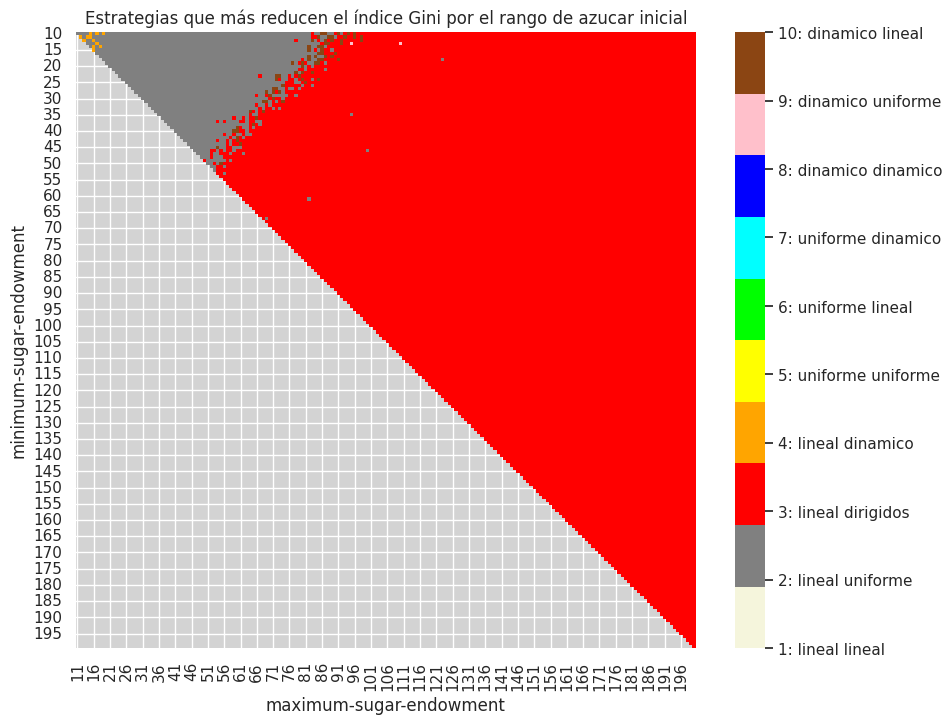

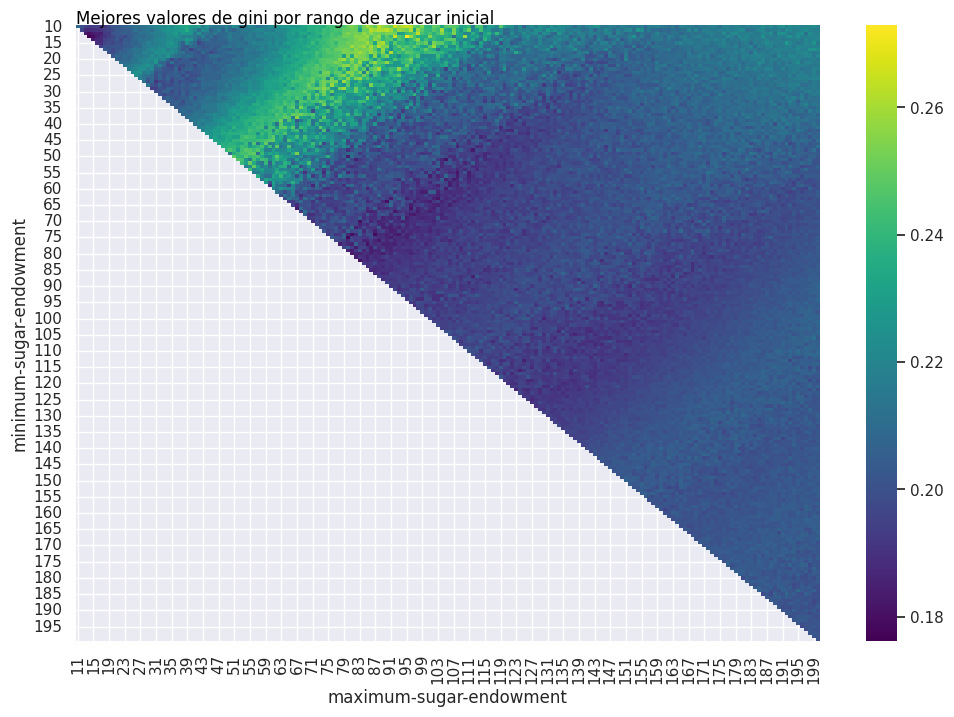

In [10]:
ruta = ruta_resultados + 'gini_estrategias'
df_gini = mejores_resultados(experimentos,'avg-gini')
mapa_resultados_gini = representacion_visual(df_gini, "Estrategias que más reducen el índice Gini por el rango de azucar inicial", ruta)
exp_gini = Experimento(dataset=df_gini)
ruta = ruta_resultados + 'mejores_gini'
exp_gini.mapa_calor('avg-gini','Mejores valores de gini por rango de azucar inicial', ruta)

## Mejor politica para reducir los decesos por hambruna

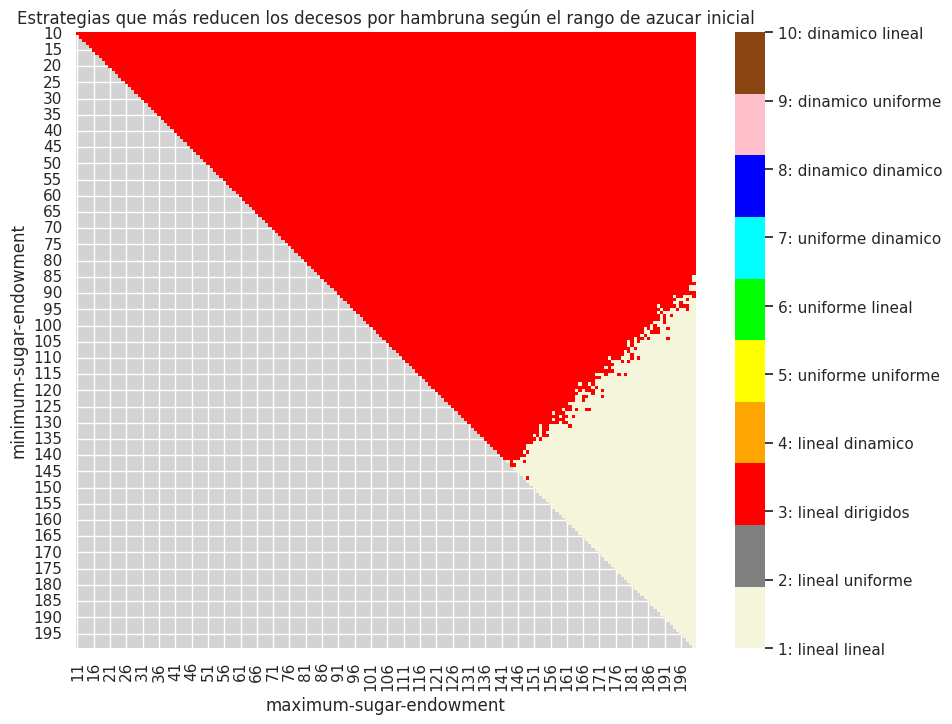

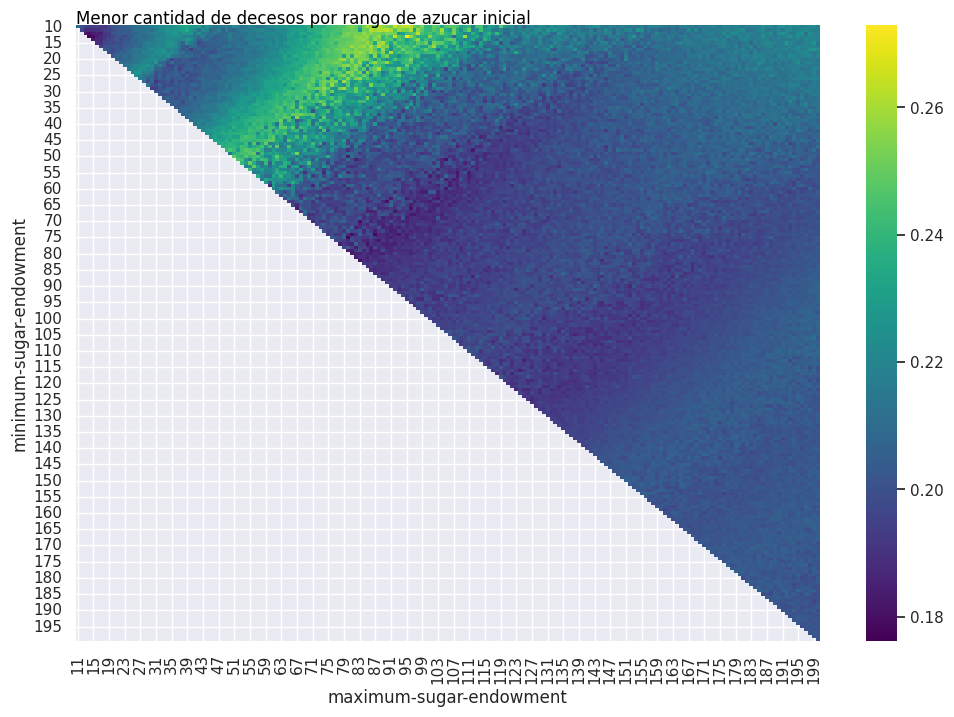

In [11]:
ruta = ruta_resultados + 'decesos_estrategias'
df_decesos = mejores_resultados(experimentos,'starvation')
mapa_resultados_decesos = representacion_visual(df_decesos, 
                                                "Estrategias que más reducen los decesos por hambruna según el rango de azucar inicial",
                                                ruta)
exp_decesos = Experimento(dataset=df_decesos)
ruta = ruta_resultados + 'Cantidad menor de decesos'
exp_gini.mapa_calor('avg-gini','Menor cantidad de decesos por rango de azucar inicial', ruta)

## Mejor politica para maximizar la riqueza per cápita

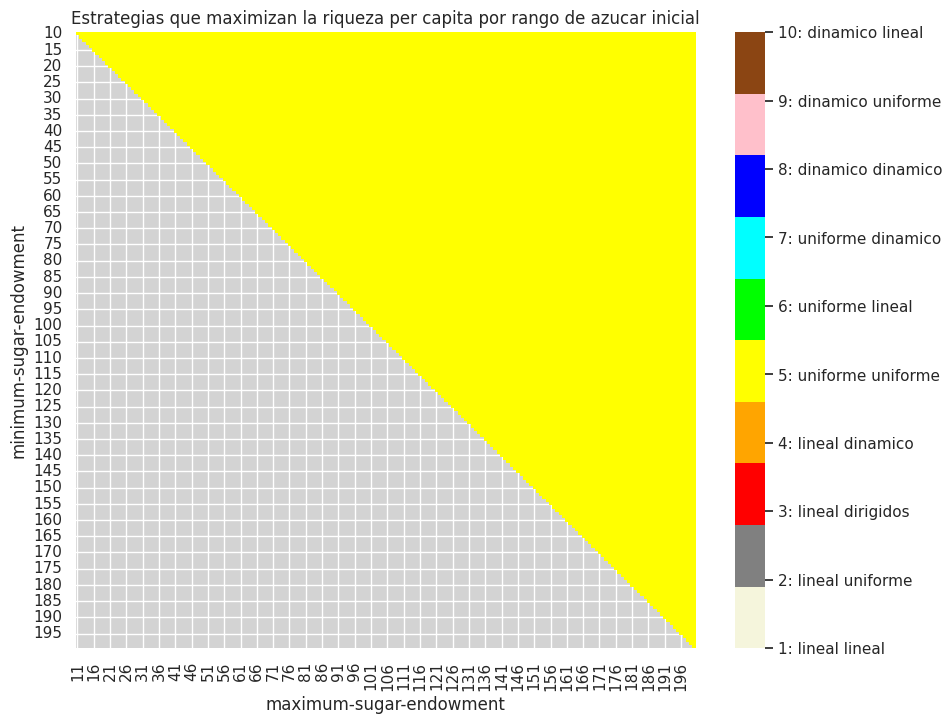

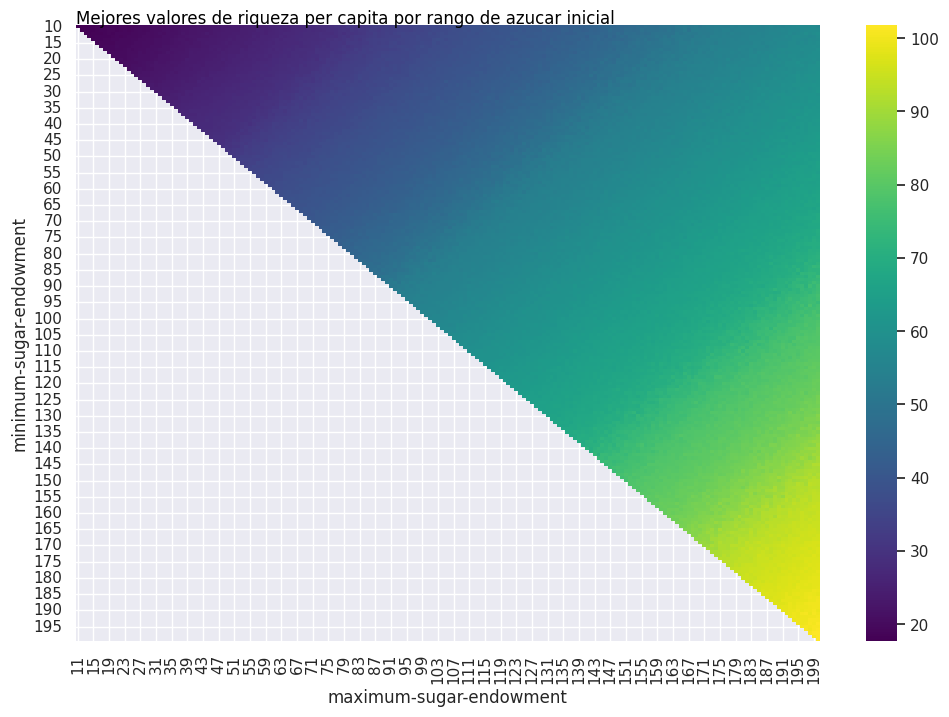

In [12]:
ruta = ruta_resultados + 'Riqueza_estrategias'
df_wealth = mejores_resultados(experimentos,'avg-wealth')
mapa_resultados_riqueza = representacion_visual(df_wealth, 
                                                "Estrategias que maximizan la riqueza per capita por rango de azucar inicial",
                                                ruta)
exp_wealth = Experimento(dataset=df_wealth)
ruta = ruta_resultados + 'Riquezas mas altas'
exp_wealth.mapa_calor('avg-wealth','Mejores valores de riqueza per capita por rango de azucar inicial', ruta)

## Mejor política para minimizar los cambios de azúcar de un tick a otro

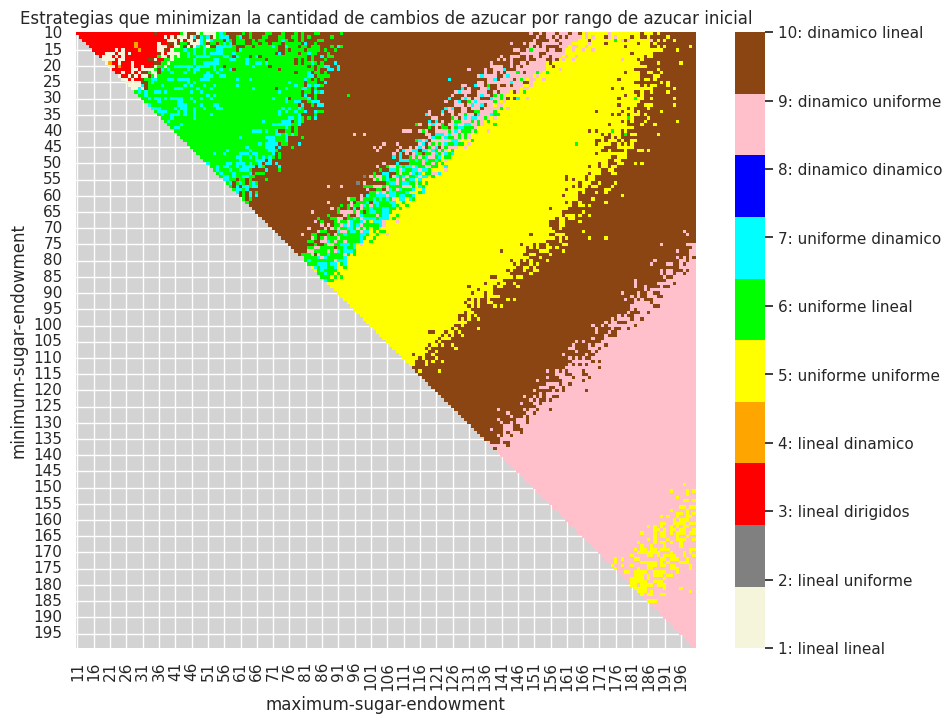

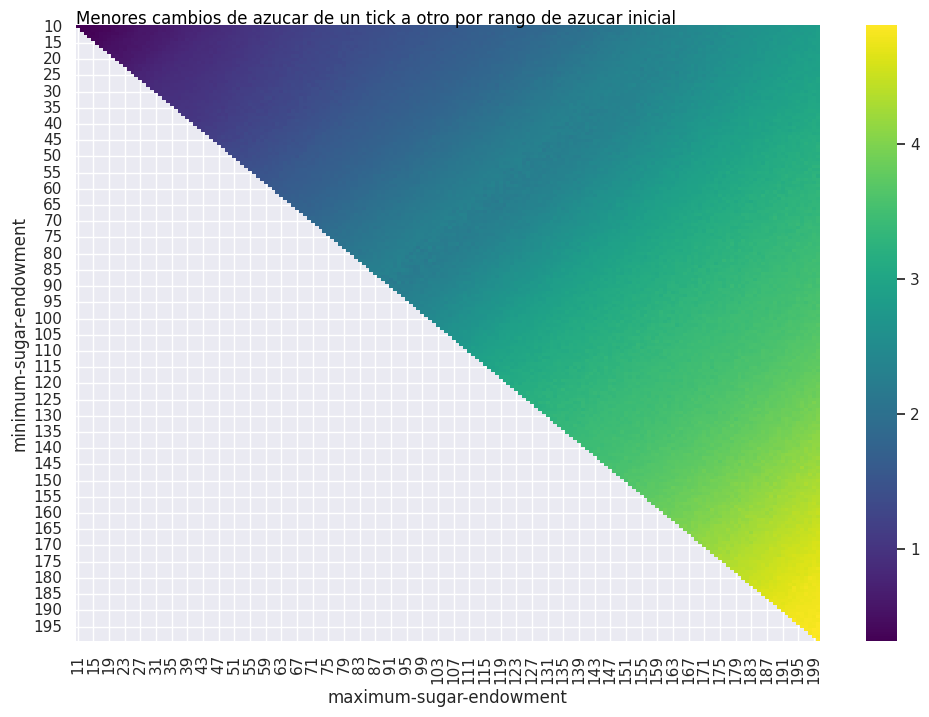

In [13]:
ruta = ruta_resultados + 'Cambios_estrategias'
df_diff = mejores_resultados(experimentos,'avg-diff')
mapa_resultados_diff = representacion_visual(df_diff, 
                                                "Estrategias que minimizan la cantidad de cambios de azucar por rango de azucar inicial",
                                                ruta)
exp_diff = Experimento(dataset=df_diff)
ruta = ruta_resultados + 'Cambios menores'
exp_diff.mapa_calor('avg-diff','Menores cambios de azucar de un tick a otro por rango de azucar inicial', ruta)

# Guardando los datasets

In [17]:
ruta_mejores_valores = ruta_datasets +'/comparativas/' 
df_gini.to_csv(ruta_mejores_valores + 'mejores_gini.csv', index=False)
df_decesos.to_csv(ruta_mejores_valores + 'decesos_mas_bajos.csv', index=False)
df_wealth.to_csv(ruta_mejores_valores + 'mejores_riquezas.csv', index=False)

# Ponderación de resultados

In [18]:
def crea_proyeccion(df, metrica_base=None, metrica_comp=None, titulo=None, ruta=None,  normalizacion= False):
    """
    Función que realiza un gráfico en R2 que compara
    los valores de dos métricas diferentes.
    
    Parámetros:
    - df (pd.DataFrame): el dataframe de donde se tomarán los datos.
    - metrica_base (str): la métrica que se tomó como base para obtener los mejores resultados.
    - metrica_comp (str): la otra métrica a comparar.
    - titulo (str): el titulo del grafico
    - ruta (str): ruta donde se guardará la imagen del gráfico.
    
    Retorna:
    - plt.fig: una imagen de la gráfica de interés.
    """
    scaler = MinMaxScaler()
    # Copiar el dataframe para no modificar el original
    df_normalizado = df.copy()

    # Escalar métricas si no son 'avg-gini'
    if normalizacion and metrica_base != 'avg-gini':
        df_normalizado[metrica_base] = scaler.fit_transform(df[[metrica_base]])
    if normalizacion and metrica_comp != 'avg-gini':
        df_normalizado[metrica_comp] = scaler.fit_transform(df[[metrica_comp]])

    # Graficar los valores normalizados
    plt.figure(figsize=(8, 6))
    plt.scatter(df_normalizado[metrica_base], df_normalizado[metrica_comp], alpha=0.7)
    plt.xlabel(metrica_base)
    plt.ylabel(metrica_comp)
    plt.title(titulo)
    plt.grid(True)
    plt.savefig(ruta, dpi=300, bbox_inches='tight')
    plt.show()


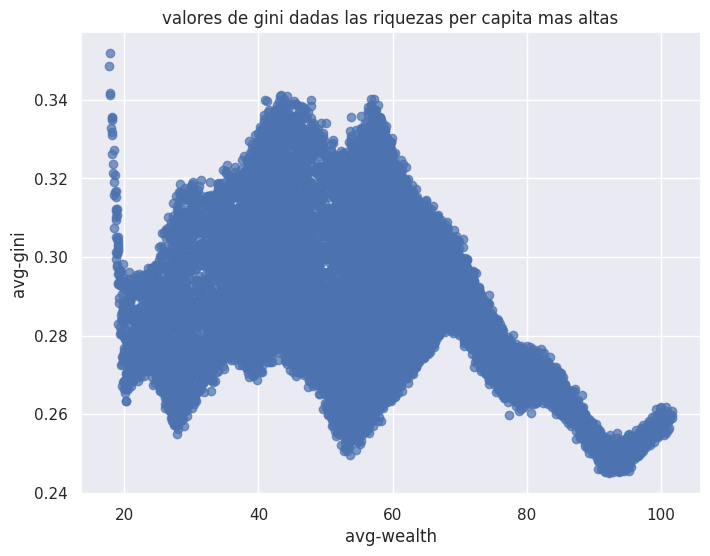

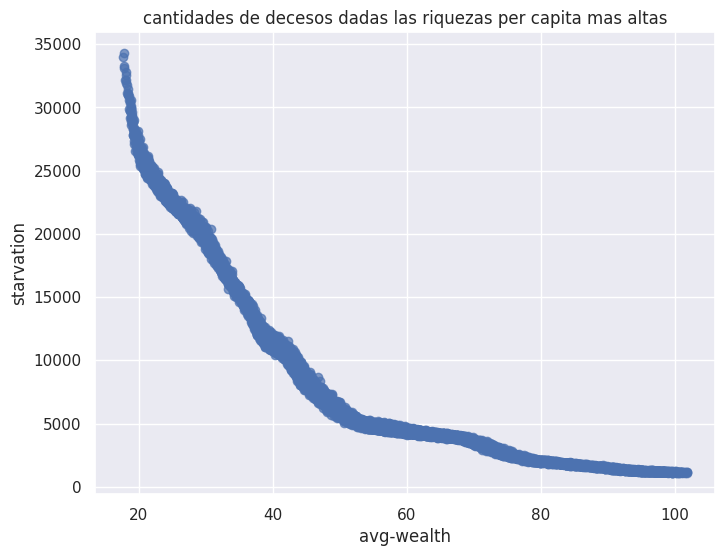

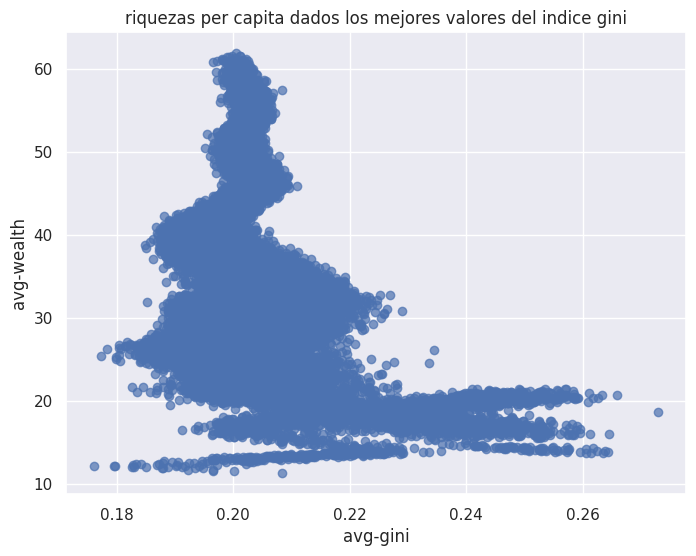

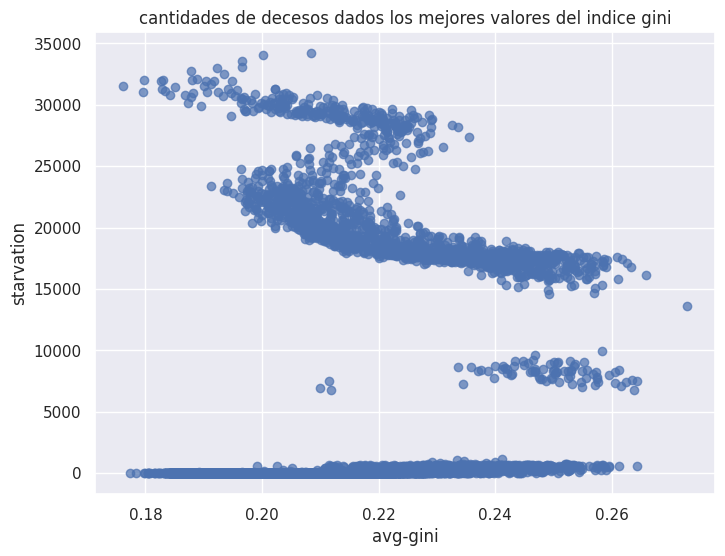

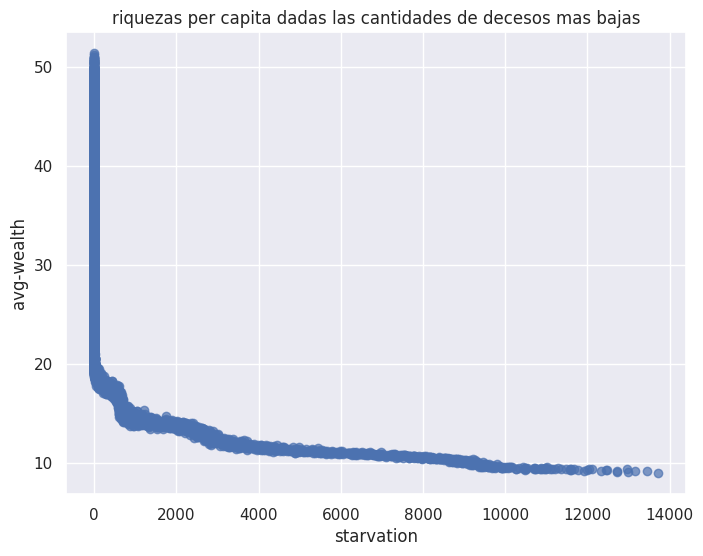

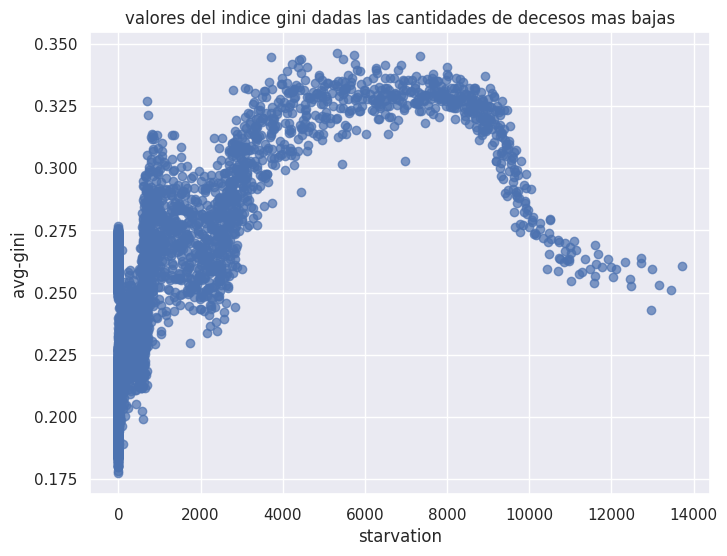

In [19]:

# Definición de listas
metricas = ['avg-wealth', 'avg-gini', 'starvation']
mejores_resultados = [df_wealth, df_gini, df_decesos]
titulos = ['valores de gini dadas las riquezas per capita mas altas',
           'cantidades de decesos dadas las riquezas per capita mas altas',
           'riquezas per capita dados los mejores valores del indice gini',
           'cantidades de decesos dados los mejores valores del indice gini',
           'riquezas per capita dadas las cantidades de decesos mas bajas',
           'valores del indice gini dadas las cantidades de decesos mas bajas' 
          ]
ruta = ruta_resultados + '/graficas/'
crea_proyeccion(df_wealth, 'avg-wealth', 'avg-gini',titulos[0], ruta+titulos[0])
crea_proyeccion(df_wealth, 'avg-wealth', 'starvation',titulos[1], ruta+titulos[1])
crea_proyeccion(df_gini, 'avg-gini', 'avg-wealth',titulos[2], ruta+titulos[2])
crea_proyeccion(df_gini, 'avg-gini', 'starvation',titulos[3], ruta+titulos[3])
crea_proyeccion(df_decesos, 'starvation', 'avg-wealth',titulos[4], ruta+titulos[4])
crea_proyeccion(df_decesos, 'starvation', 'avg-gini',titulos[5], ruta+titulos[5])

In [20]:

def grafico_3d(df, metrica_base, metrica_y, metrica_z, ruta):
    """
    Crea un gráfico 3D con los valores de las columnas
    especificadas del DataFrame.

    Parámetros:
    - df (pd.DataFrame): DataFrame que contiene los datos a graficar.
    - metrica_base (str): Nombre de la columna para el eje X.
    - metrica_y (str): Nombre de la columna para el eje Y.
    - metrica_z (str): Nombre de la columna para el eje Z.
    """
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    # Extrae los datos de cada columna
    x = df[metrica_base]
    y = df[metrica_y]
    z = df[metrica_z]
    
    # Crea el scatter plot 3D
    ax.scatter(x, y, z, c=z, cmap='viridis', marker='o', alpha=0.8)
    
    # Etiquetas y título
    ax.set_xlabel(metrica_base)
    ax.set_ylabel(metrica_y)
    ax.set_zlabel(metrica_z)
    ax.set_title(f'Gráfico 3D de {metrica_base} vs {metrica_y} vs {metrica_z}')
    plt.savefig(ruta, dpi=300, bbox_inches='tight')
    plt.show()


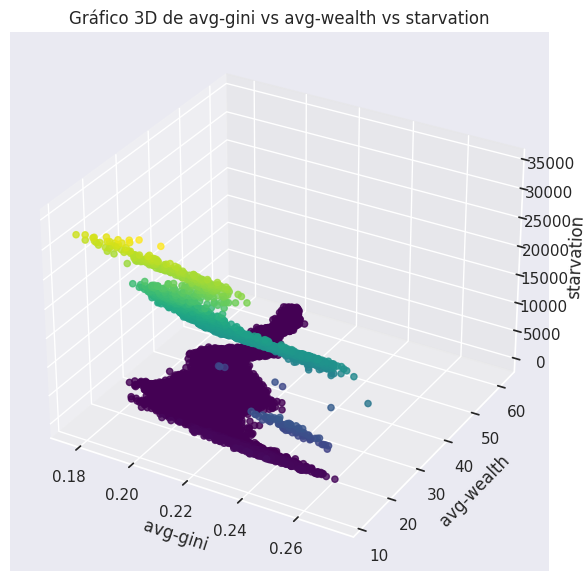

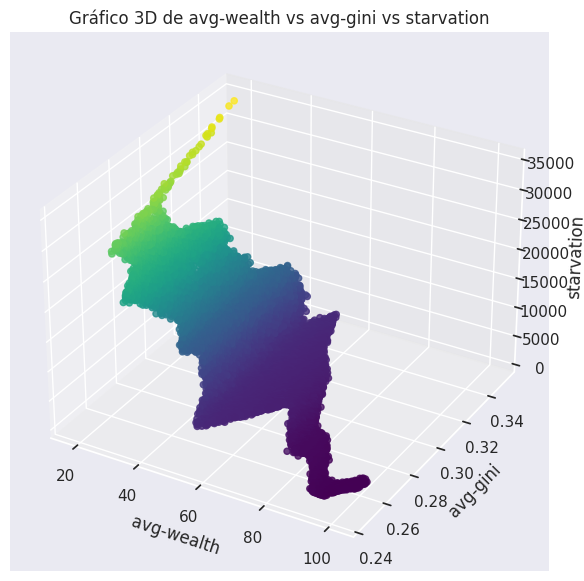

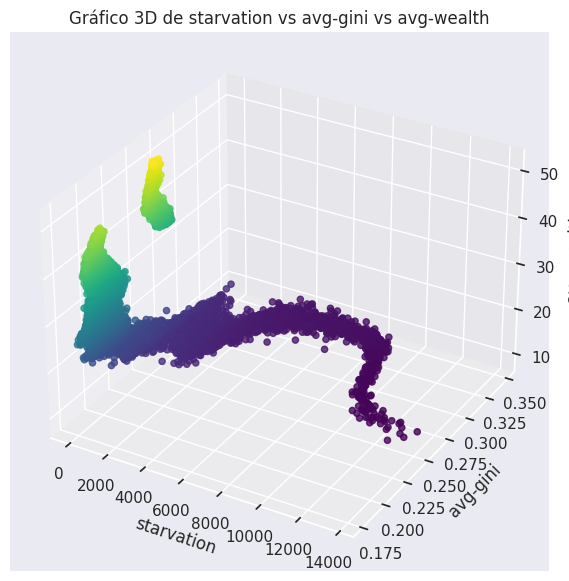

In [21]:

grafico_3d(df_gini, 'avg-gini', 'avg-wealth','starvation', ruta+'Indice gini R3')
grafico_3d(df_wealth, 'avg-wealth', 'avg-gini','starvation', ruta+'Riqueza R3')
grafico_3d(df_decesos, 'starvation', 'avg-gini', 'avg-wealth', ruta+'Decesos R3')


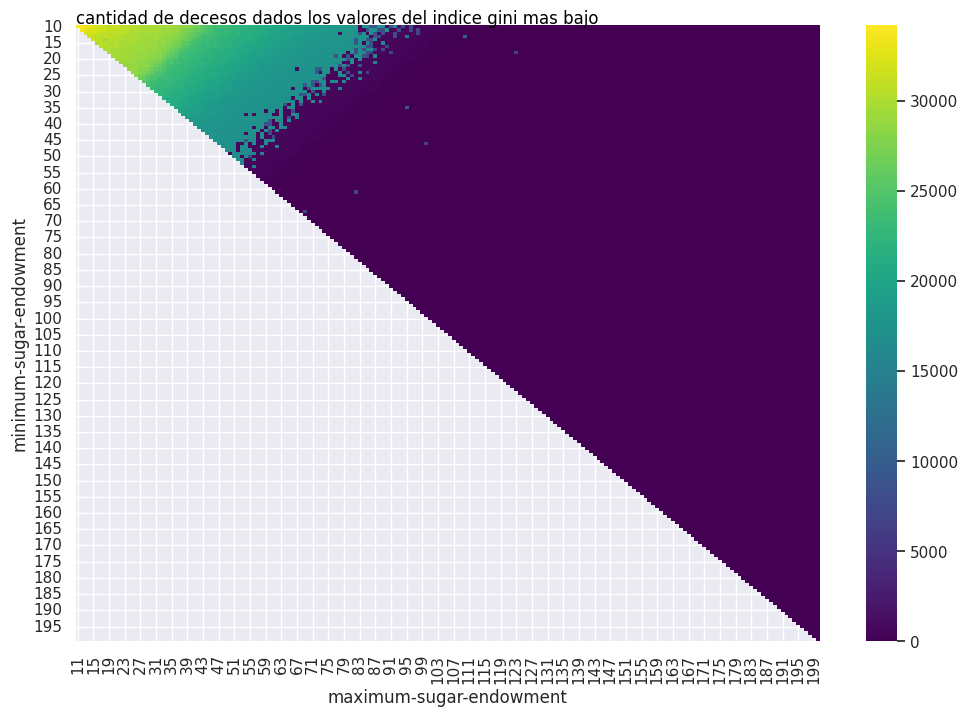

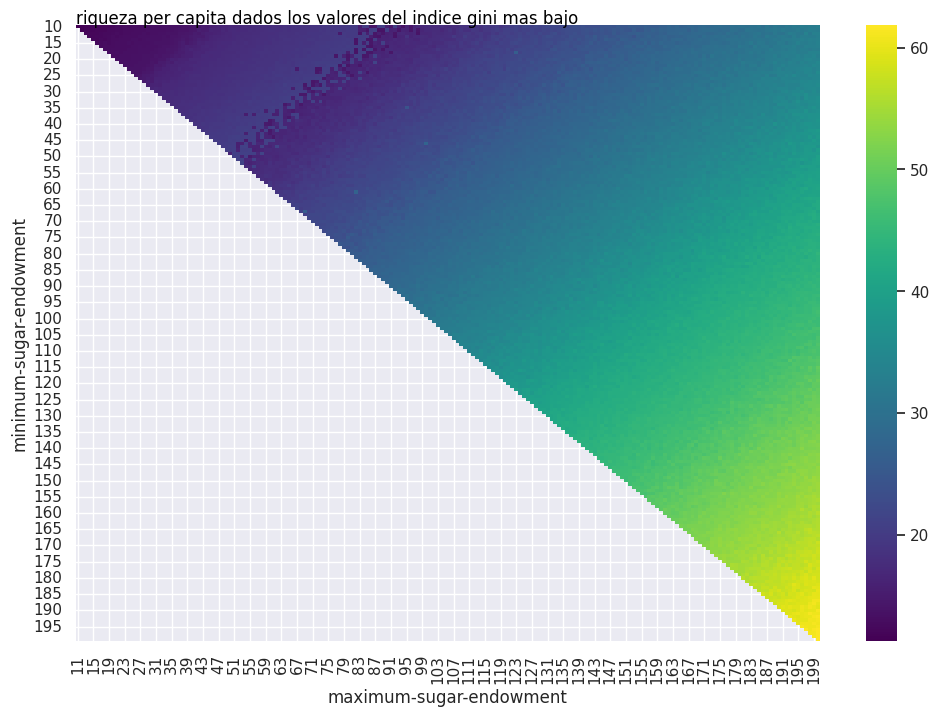

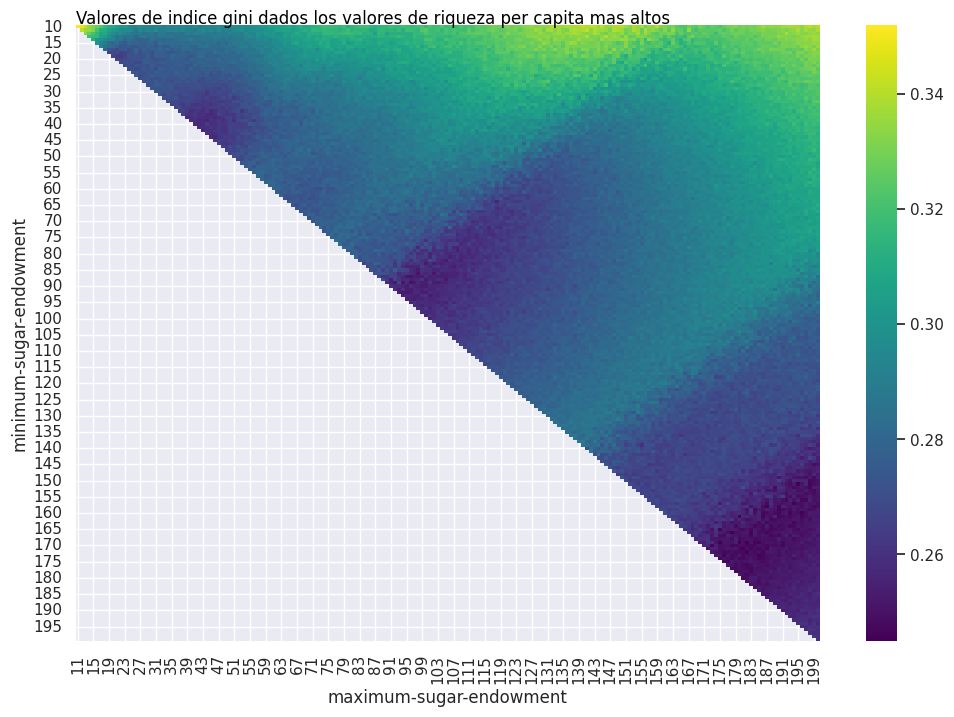

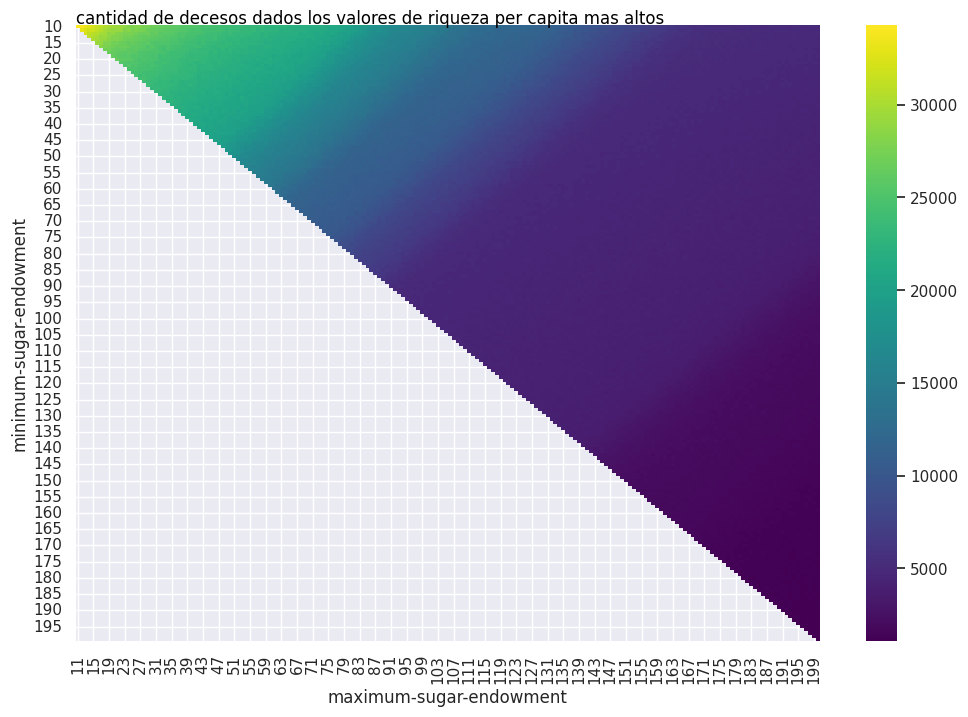

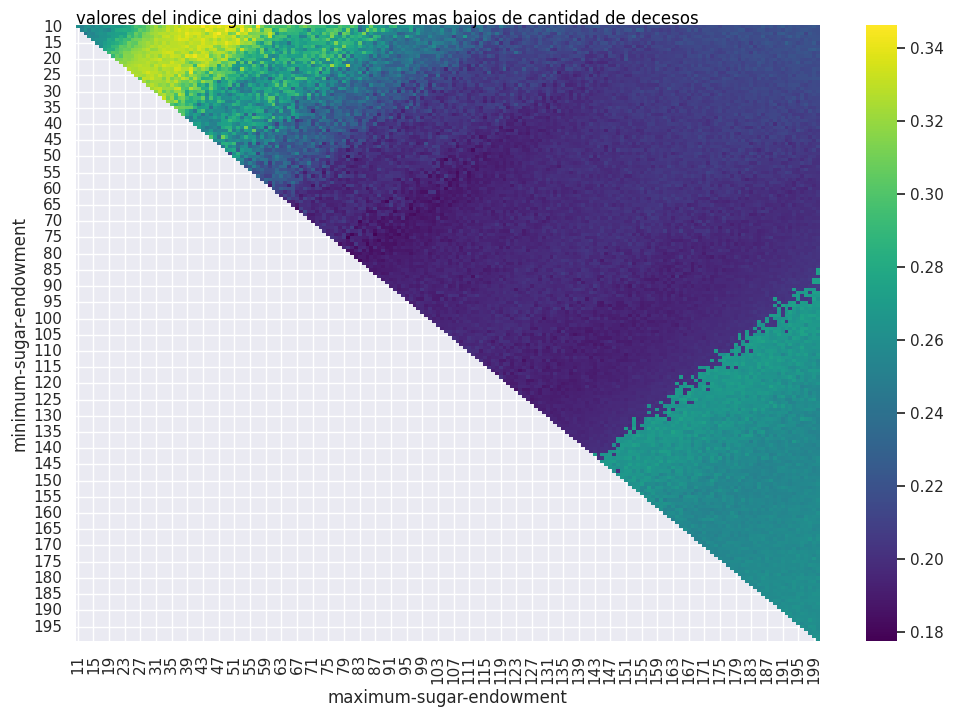

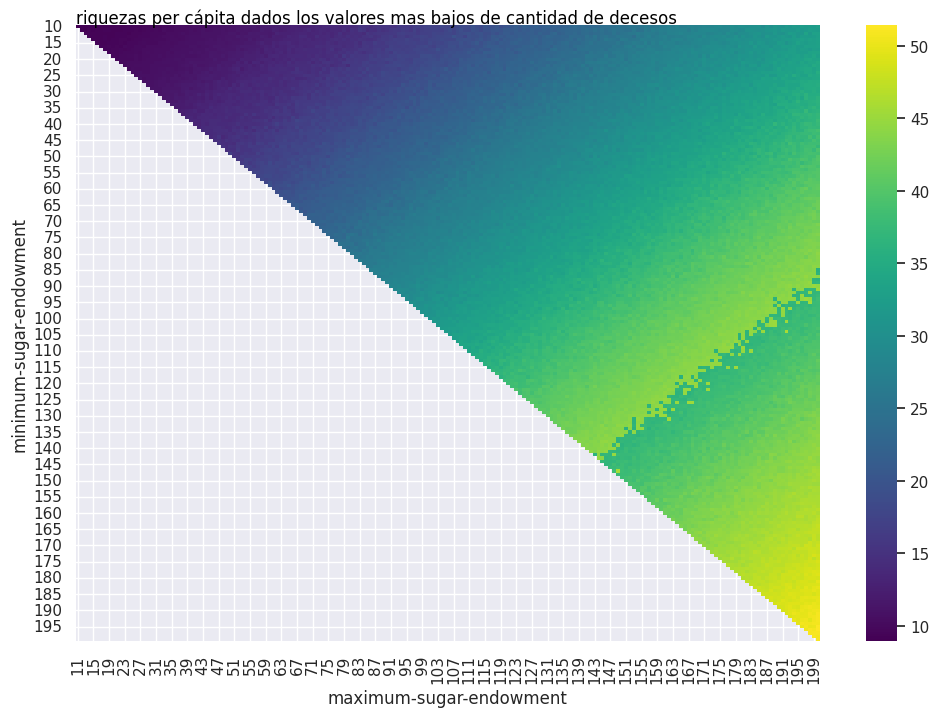

In [22]:
ruta = ruta_resultados + 'decesos dado gini'
exp_gini.mapa_calor('starvation','cantidad de decesos dados los valores del indice gini mas bajo', ruta)
ruta = ruta_resultados + 'riquezas dado gini'
exp_gini.mapa_calor('avg-wealth','riqueza per capita dados los valores del indice gini mas bajo', ruta)

ruta = ruta_resultados + 'gini dado riqueza'
exp_wealth.mapa_calor('avg-gini','Valores de indice gini dados los valores de riqueza per capita mas altos', ruta)
ruta = ruta_resultados + 'decesos dado riqueza'
exp_wealth.mapa_calor('starvation','cantidad de decesos dados los valores de riqueza per capita mas altos', ruta)

ruta = ruta_resultados + 'gini dado decesos'
exp_decesos.mapa_calor('avg-gini','valores del indice gini dados los valores mas bajos de cantidad de decesos', ruta)
ruta = ruta_resultados + 'riquezas dado decesos'
exp_decesos.mapa_calor('avg-wealth','riquezas per cápita dados los valores mas bajos de cantidad de decesos', ruta)
